<a href="https://colab.research.google.com/github/jaesunkkk/KOSIS-AI-competition/blob/main/Xlmroberta_si.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==3.0.2
!pip install tqdm

In [ ]:
import pandas as pd
import numpy as np
import pickle
import copy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# Models
from transformers import XLMRobertaConfig, XLMRobertaTokenizer, XLMRobertaForSequenceClassification

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
xlmroberta = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=225)

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weig

In [ ]:
!pip install GPUtil
from GPUtil import showUtilization as gpu_usage
gpu_usage()

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=661a435fb05e516360bdbfc959cb0e57b70e9acae3f74572c8df9e91d5899503
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [ ]:
train_path = '/content/drive/MyDrive/indclass/train_augmented.csv'
test_path = '/content/drive/MyDrive/indclass/test.txt'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path, sep='|', encoding = 'cp949')

In [ ]:
train_original = pd.read_csv('/content/drive/MyDrive/indclass/train_augmented_0.csv')

In [ ]:
train_df.drop(columns=['Unnamed: 0'], inplace=True)

### NLP

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

!pip install konlpy
import konlpy
from konlpy.tag import Mecab
mecab = Mecab()

In [ ]:
def tokenize(sent):
  try:
    tokens = " ".join((mecab.nouns(sent)))
  
  except:
    tokens = " "
    
  return tokens

### modules

In [ ]:
def sent_tokenizer(sent, MAX_LEN):
  encoded_dict = tokenizer(text = sent,
                            add_special_tokens = True,
                            padding = 'max_length',
                            max_length = MAX_LEN,
                            is_pretokenized = True,
                            truncation = True,
                            return_attention_mask=True)

  input_ids = encoded_dict['input_ids']
  attention_mask = encoded_dict['attention_mask']

  return input_ids, attention_mask

def dataset_tokenizer(args, dataset, target):

  input_ids_ = []
  attention_mask_ = []
  targets_ = []

  for sent in tqdm(dataset):
    try :
      input_ids, attention_mask = sent_tokenizer(sent, MAX_LEN = args['max_seq_length'])

      input_ids_.append(input_ids)
      attention_mask_.append(attention_mask)

    except :
      pass
  
  input_ids_ = np.array(input_ids_, dtype=int)
  attention_mask_ = np.array(attention_mask_, dtype=int)
  targets_ = np.array(target, dtype=int) 
                             
  dataset_tokenized = {}
  dataset_tokenized['input_ids'] = input_ids_
  dataset_tokenized['attention_mask'] = attention_mask_
  dataset_tokenized['targets'] = targets_

  # save file
  with open('/content/drive/MyDrive/indclass/roberta_tokenized_original.pickle', 'wb') as f:
    pickle.dump(dataset_tokenized, f, pickle.HIGHEST_PROTOCOL)
  
  # return dataset_tokenized

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataset, test=False):

        self.dataset = dataset
        self.test = test

    def __len__(self):

        return self.dataset['input_ids'].shape[0]

    def __getitem__(self, idx):

        ids = torch.tensor(self.dataset['input_ids'][idx], dtype=torch.long)
        masks = torch.tensor(self.dataset['attention_mask'][idx], dtype=torch.long)
        # token_type_ids = torch.tensor(self.data['token_type_ids'][idx], dtype=torch.long)
        targets = torch.tensor(self.dataset['targets'][idx], dtype=torch.long)

        if self.test:
            return {
                'ids': ids,
                'masks': masks,
            }

        else:

            return {
                'ids': ids,
                'masks': masks,
                'targets': targets
            }

In [ ]:
def do_valid(model, valid_loader):
  
  loss_func = nn.CrossEntropyLoss()
  val_loss = 0
  output_ = []
  target_ = []
  model.eval()
  
  for batch in tqdm(valid_loader, desc="validation", leave=True):

    ids, masks, targets = batch['ids'].to(device), batch['masks'].to(device), batch['targets'].to(device)

    with torch.no_grad():
      outputs = model(input_ids = ids, attention_mask = masks)
      outputs = outputs[0]

      softmax_func = torch.nn.Softmax(dim=0)
      outputs = softmax_func(outputs)

      loss = loss_func(outputs, targets)

    val_loss += loss

    output_.extend(outputs.argmax(dim=1).tolist())
    target_.extend(targets.detach().cpu().numpy())

  valid_loss_mean = val_loss / len(valid_loader)
  valid_acc_score = accuracy_score(y_true=target_, y_pred=output_)
  valid_f1_score = f1_score(y_true=target_, y_pred=output_, average='macro')

  return valid_loss_mean, valid_acc_score, valid_f1_score

In [ ]:
def get_index(targets):

  idxs = pd.DataFrame()
  idxs['idx'] = list(range(len(targets)))
  idxs['target'] = targets

  idxs = idxs[~idxs.target.isin([6,7])]
  train_idx, valid_idx = train_test_split(idxs.idx, test_size=0.1, random_state=777, stratify=idxs.target)

  return train_idx, valid_idx

In [ ]:
def run_train(args, model):

  with open('/content/drive/MyDrive/indclass/roberta_tokenized_original.pickle', 'rb') as f:
    train_data = pickle.load(f)

  # train, valid set index 
  # data_len = len(train_data['targets'])
  # train_idx = np.random.choice(data_len, int((data_len)*0.8), replace=False)
  # val_idx = np.setdiff1d(range(data_len), train_idx)
  targets = train_data['targets']
  train_idx, val_idx = get_index(targets)

  train_dict = {'input_ids': train_data['input_ids'][train_idx],
                      'attention_mask': train_data['attention_mask'][train_idx],
                      'targets': train_data['targets'][train_idx]}

  valid_dict = {'input_ids': train_data['input_ids'][val_idx],
                    'attention_mask': train_data['attention_mask'][val_idx],
                    'targets': train_data['targets'][val_idx]}

  train_set = CustomDataset(dataset = train_dict)
  valid_set = CustomDataset(dataset = valid_dict)
  train_loader = DataLoader(dataset = train_set, batch_size = args['train_batch_size'], shuffle=True)
  valid_loader = DataLoader(dataset = valid_set, batch_size = args['valid_batch_size'], shuffle=True)

  global best_f1_score
  global best_state_dict

  loss_func = nn.CrossEntropyLoss()
  optimizer = optim.RAdam(params = model.parameters(), lr = args['learning_rate'])

  model.to(device)

  train_acc_score_ = []
  valid_acc_score_ = []
  train_f1_score_ = []
  valid_f1_score_ = []

  for epoch in range(1, args['train_epochs']+1):

    print(f"[Epoch {epoch}]" + "\n")

    train_loss = 0
    output_ = []
    target_ = []
    model.train()

    for step, batch in enumerate(tqdm(train_loader, desc="train")) :

      ids, masks, targets = batch['ids'].to(device), batch['masks'].to(device), batch['targets'].to(device)

      optimizer.zero_grad()
      outputs = model(input_ids = ids, attention_mask = masks)
      outputs = outputs[0]
      softmax_func = torch.nn.Softmax(dim=0)
      outputs = softmax_func(outputs)

      loss = loss_func(outputs, targets)
      if not torch.isfinite(loss):
        print("Warning : non-finite loss")
        loss=5
      loss.backward()

      optimizer.step()

      output_.extend(outputs.argmax(dim=1).tolist())
      target_.extend(targets.detach().cpu().numpy())

      train_acc_score = accuracy_score(y_true = target_, y_pred = output_)
      train_f1_score = f1_score(y_true = target_, y_pred = output_, average='macro')
      train_acc_score_.append(train_acc_score)
      train_f1_score_.append(train_f1_score)

      if step % 400 == 0 :
        valid_loss, valid_acc_score, valid_f1_score = do_valid(model, valid_loader)
        valid_acc_score_.append(valid_acc_score)
        valid_f1_score_.append(valid_f1_score)

        print(f"[Step] {step}" + "\n")
        print(f"[train] loss : {loss:.3f} accuracy : {train_acc_score:.3f} f1 score : {train_f1_score:.3f}" + "\n")
        print(f"[validation] loss : {valid_loss:.3f} accuracy : {valid_acc_score:.3f} f1 score : {valid_f1_score:.3f}" + "\n")

        if valid_f1_score > best_f1_score :
          best_f1_score = valid_f1_score
          best_state_dict = copy.deepcopy(model.state_dict())

        torch.cuda.empty_cache()
    
    torch.save(best_state_dict, model_path)
  
  try :
    scores = {'train_acc' : train_acc_score_, 'valid_acc' : valid_acc_score_, 'train_f1' : train_f1_score_, 'valid_f1' : valid_f1_score_}
    with open('/content/drive/MyDrive/indclass/scores2.pickle', 'wb') as f :
      pickle.dump(scores, f)
  except :
    pass


### training

In [ ]:
# best state 저장
global best_f1_score
best_f1_score = 0
global best_state_dict
best_state_dict = None

model_path = '/content/drive/MyDrive/indclass/xlmroberta.pth'

In [ ]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# model argument 

args = {'train_batch_size' : 32,
        'valid_batch_size' : 32,
        'max_seq_length': 32, 
        'learning_rate': 2e-05,
        'train_epochs' : 5,
        }

In [ ]:
dataset_tokenizer(args, train_df['text'], train_df['target'])

  0%|          | 0/588338 [00:00<?, ?it/s]

In [ ]:
dataset_tokenizer(args, train_original['text'], train_original['target'])

  0%|          | 0/372361 [00:00<?, ?it/s]

In [ ]:
run_train(args, xlmroberta)

### original로 

In [ ]:
xlmroberta_ = torch.load(model_path)

In [ ]:
xlmroberta.load_state_dict(xlmroberta_)

<All keys matched successfully>

In [ ]:
run_train(args, xlmroberta)

[Epoch 1]



train:   0%|          | 0/9294 [00:00<?, ?it/s]

validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 0

[train] loss : 4.823 accuracy : 0.719 f1 score : 0.556

[validation] loss : 4.692 accuracy : 0.689 f1 score : 0.534



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 400

[train] loss : 4.708 accuracy : 0.702 f1 score : 0.544

[validation] loss : 4.677 accuracy : 0.705 f1 score : 0.561



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 800

[train] loss : 4.626 accuracy : 0.704 f1 score : 0.554

[validation] loss : 4.670 accuracy : 0.714 f1 score : 0.579



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 1200

[train] loss : 4.728 accuracy : 0.708 f1 score : 0.564

[validation] loss : 4.666 accuracy : 0.718 f1 score : 0.583



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 1600

[train] loss : 4.724 accuracy : 0.711 f1 score : 0.570

[validation] loss : 4.660 accuracy : 0.722 f1 score : 0.589



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 2000

[train] loss : 4.733 accuracy : 0.713 f1 score : 0.577

[validation] loss : 4.657 accuracy : 0.719 f1 score : 0.592



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 2400

[train] loss : 4.619 accuracy : 0.716 f1 score : 0.583

[validation] loss : 4.656 accuracy : 0.728 f1 score : 0.607



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 2800

[train] loss : 4.598 accuracy : 0.718 f1 score : 0.590

[validation] loss : 4.652 accuracy : 0.731 f1 score : 0.614



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 3200

[train] loss : 4.604 accuracy : 0.719 f1 score : 0.594

[validation] loss : 4.652 accuracy : 0.729 f1 score : 0.615



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 3600

[train] loss : 4.594 accuracy : 0.721 f1 score : 0.598

[validation] loss : 4.647 accuracy : 0.734 f1 score : 0.626



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 4000

[train] loss : 4.671 accuracy : 0.721 f1 score : 0.600

[validation] loss : 4.649 accuracy : 0.729 f1 score : 0.619



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 4400

[train] loss : 4.603 accuracy : 0.723 f1 score : 0.603

[validation] loss : 4.645 accuracy : 0.733 f1 score : 0.632



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 4800

[train] loss : 4.674 accuracy : 0.722 f1 score : 0.603

[validation] loss : 4.647 accuracy : 0.730 f1 score : 0.619



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 5200

[train] loss : 4.598 accuracy : 0.723 f1 score : 0.605

[validation] loss : 4.642 accuracy : 0.734 f1 score : 0.631



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 5600

[train] loss : 4.628 accuracy : 0.723 f1 score : 0.607

[validation] loss : 4.640 accuracy : 0.738 f1 score : 0.639



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 6000

[train] loss : 4.610 accuracy : 0.724 f1 score : 0.610

[validation] loss : 4.635 accuracy : 0.741 f1 score : 0.647



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 6400

[train] loss : 4.622 accuracy : 0.725 f1 score : 0.612

[validation] loss : 4.636 accuracy : 0.742 f1 score : 0.653



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 6800

[train] loss : 4.571 accuracy : 0.726 f1 score : 0.614

[validation] loss : 4.637 accuracy : 0.742 f1 score : 0.652



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 7200

[train] loss : 4.638 accuracy : 0.727 f1 score : 0.616

[validation] loss : 4.634 accuracy : 0.744 f1 score : 0.652



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 7600

[train] loss : 4.615 accuracy : 0.728 f1 score : 0.617

[validation] loss : 4.631 accuracy : 0.745 f1 score : 0.657



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 8000

[train] loss : 4.719 accuracy : 0.728 f1 score : 0.619

[validation] loss : 4.635 accuracy : 0.740 f1 score : 0.651



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 8400

[train] loss : 4.642 accuracy : 0.729 f1 score : 0.620

[validation] loss : 4.633 accuracy : 0.745 f1 score : 0.659



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 8800

[train] loss : 4.581 accuracy : 0.730 f1 score : 0.622

[validation] loss : 4.631 accuracy : 0.744 f1 score : 0.665



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 9200

[train] loss : 4.600 accuracy : 0.731 f1 score : 0.625

[validation] loss : 4.632 accuracy : 0.742 f1 score : 0.655

[Epoch 2]



train:   0%|          | 0/9294 [00:00<?, ?it/s]

validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 0

[train] loss : 4.692 accuracy : 0.688 f1 score : 0.538

[validation] loss : 4.629 accuracy : 0.749 f1 score : 0.665



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 400

[train] loss : 4.700 accuracy : 0.760 f1 score : 0.676

[validation] loss : 4.626 accuracy : 0.754 f1 score : 0.670



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 800

[train] loss : 4.676 accuracy : 0.761 f1 score : 0.680

[validation] loss : 4.629 accuracy : 0.750 f1 score : 0.677



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 1200

[train] loss : 4.656 accuracy : 0.761 f1 score : 0.685

[validation] loss : 4.626 accuracy : 0.754 f1 score : 0.669



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 1600

[train] loss : 4.661 accuracy : 0.759 f1 score : 0.680

[validation] loss : 4.642 accuracy : 0.716 f1 score : 0.631



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 2000

[train] loss : 4.674 accuracy : 0.757 f1 score : 0.678

[validation] loss : 4.631 accuracy : 0.745 f1 score : 0.665



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 2400

[train] loss : 4.515 accuracy : 0.757 f1 score : 0.677

[validation] loss : 4.628 accuracy : 0.752 f1 score : 0.675



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 2800

[train] loss : 4.583 accuracy : 0.756 f1 score : 0.677

[validation] loss : 4.628 accuracy : 0.747 f1 score : 0.670



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 3200

[train] loss : 4.556 accuracy : 0.757 f1 score : 0.678

[validation] loss : 4.625 accuracy : 0.752 f1 score : 0.671



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 3600

[train] loss : 4.675 accuracy : 0.758 f1 score : 0.679

[validation] loss : 4.624 accuracy : 0.756 f1 score : 0.678



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 4000

[train] loss : 4.610 accuracy : 0.758 f1 score : 0.681

[validation] loss : 4.628 accuracy : 0.752 f1 score : 0.671



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 4400

[train] loss : 4.494 accuracy : 0.759 f1 score : 0.681

[validation] loss : 4.623 accuracy : 0.758 f1 score : 0.684



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 4800

[train] loss : 4.560 accuracy : 0.760 f1 score : 0.683

[validation] loss : 4.624 accuracy : 0.759 f1 score : 0.688



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 5200

[train] loss : 4.595 accuracy : 0.760 f1 score : 0.683

[validation] loss : 4.623 accuracy : 0.755 f1 score : 0.684



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 5600

[train] loss : 4.693 accuracy : 0.760 f1 score : 0.684

[validation] loss : 4.625 accuracy : 0.752 f1 score : 0.681



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 6000

[train] loss : 4.619 accuracy : 0.759 f1 score : 0.684

[validation] loss : 4.623 accuracy : 0.752 f1 score : 0.682



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 6400

[train] loss : 4.549 accuracy : 0.759 f1 score : 0.684

[validation] loss : 4.625 accuracy : 0.752 f1 score : 0.681



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 6800

[train] loss : 4.685 accuracy : 0.759 f1 score : 0.684

[validation] loss : 4.621 accuracy : 0.754 f1 score : 0.680



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 7200

[train] loss : 4.660 accuracy : 0.759 f1 score : 0.684

[validation] loss : 4.626 accuracy : 0.748 f1 score : 0.671



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 7600

[train] loss : 4.662 accuracy : 0.759 f1 score : 0.683

[validation] loss : 4.632 accuracy : 0.726 f1 score : 0.650



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 8000

[train] loss : 4.719 accuracy : 0.759 f1 score : 0.683

[validation] loss : 4.622 accuracy : 0.749 f1 score : 0.678



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 8400

[train] loss : 4.651 accuracy : 0.759 f1 score : 0.683

[validation] loss : 4.622 accuracy : 0.754 f1 score : 0.685



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 8800

[train] loss : 4.605 accuracy : 0.759 f1 score : 0.683

[validation] loss : 4.620 accuracy : 0.756 f1 score : 0.689



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 9200

[train] loss : 4.523 accuracy : 0.759 f1 score : 0.684

[validation] loss : 4.619 accuracy : 0.760 f1 score : 0.692

[Epoch 3]



train:   0%|          | 0/9294 [00:00<?, ?it/s]

validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 0

[train] loss : 4.538 accuracy : 0.875 f1 score : 0.804

[validation] loss : 4.619 accuracy : 0.760 f1 score : 0.700



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 400

[train] loss : 4.613 accuracy : 0.770 f1 score : 0.705

[validation] loss : 4.618 accuracy : 0.762 f1 score : 0.698



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 800

[train] loss : 4.594 accuracy : 0.772 f1 score : 0.707

[validation] loss : 4.616 accuracy : 0.761 f1 score : 0.699



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 1200

[train] loss : 4.585 accuracy : 0.774 f1 score : 0.710

[validation] loss : 4.616 accuracy : 0.766 f1 score : 0.702



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 1600

[train] loss : 4.563 accuracy : 0.772 f1 score : 0.711

[validation] loss : 4.617 accuracy : 0.765 f1 score : 0.706



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 2000

[train] loss : 4.584 accuracy : 0.772 f1 score : 0.713

[validation] loss : 4.620 accuracy : 0.759 f1 score : 0.699



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 2400

[train] loss : 4.627 accuracy : 0.774 f1 score : 0.716

[validation] loss : 4.617 accuracy : 0.765 f1 score : 0.705



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 2800

[train] loss : 4.623 accuracy : 0.773 f1 score : 0.715

[validation] loss : 4.618 accuracy : 0.764 f1 score : 0.705



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 3200

[train] loss : 4.608 accuracy : 0.773 f1 score : 0.715

[validation] loss : 4.617 accuracy : 0.763 f1 score : 0.706



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 3600

[train] loss : 4.520 accuracy : 0.773 f1 score : 0.715

[validation] loss : 4.618 accuracy : 0.763 f1 score : 0.701



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 4000

[train] loss : 4.565 accuracy : 0.773 f1 score : 0.715

[validation] loss : 4.616 accuracy : 0.763 f1 score : 0.700



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 4400

[train] loss : 4.617 accuracy : 0.773 f1 score : 0.715

[validation] loss : 4.619 accuracy : 0.755 f1 score : 0.698



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 4800

[train] loss : 4.551 accuracy : 0.773 f1 score : 0.715

[validation] loss : 4.616 accuracy : 0.764 f1 score : 0.701



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 5200

[train] loss : 4.596 accuracy : 0.772 f1 score : 0.714

[validation] loss : 4.621 accuracy : 0.760 f1 score : 0.702



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 5600

[train] loss : 4.636 accuracy : 0.772 f1 score : 0.713

[validation] loss : 4.617 accuracy : 0.761 f1 score : 0.701



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 6000

[train] loss : 4.629 accuracy : 0.772 f1 score : 0.714

[validation] loss : 4.615 accuracy : 0.763 f1 score : 0.700



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 6400

[train] loss : 4.663 accuracy : 0.772 f1 score : 0.714

[validation] loss : 4.620 accuracy : 0.757 f1 score : 0.690



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 6800

[train] loss : 4.621 accuracy : 0.772 f1 score : 0.714

[validation] loss : 4.615 accuracy : 0.766 f1 score : 0.706



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 7200

[train] loss : 4.585 accuracy : 0.772 f1 score : 0.714

[validation] loss : 4.619 accuracy : 0.763 f1 score : 0.699



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 7600

[train] loss : 4.506 accuracy : 0.772 f1 score : 0.714

[validation] loss : 4.618 accuracy : 0.763 f1 score : 0.708



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 8000

[train] loss : 4.605 accuracy : 0.772 f1 score : 0.714

[validation] loss : 4.617 accuracy : 0.761 f1 score : 0.702



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 8400

[train] loss : 4.695 accuracy : 0.772 f1 score : 0.713

[validation] loss : 4.618 accuracy : 0.759 f1 score : 0.701



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 8800

[train] loss : 4.569 accuracy : 0.772 f1 score : 0.714

[validation] loss : 4.618 accuracy : 0.761 f1 score : 0.709



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 9200

[train] loss : 4.636 accuracy : 0.772 f1 score : 0.714

[validation] loss : 4.617 accuracy : 0.767 f1 score : 0.709



In [ ]:
with open('/content/drive/MyDrive/indclass/scores.pickle', 'rb') as f:
  scores = pickle.load(f)

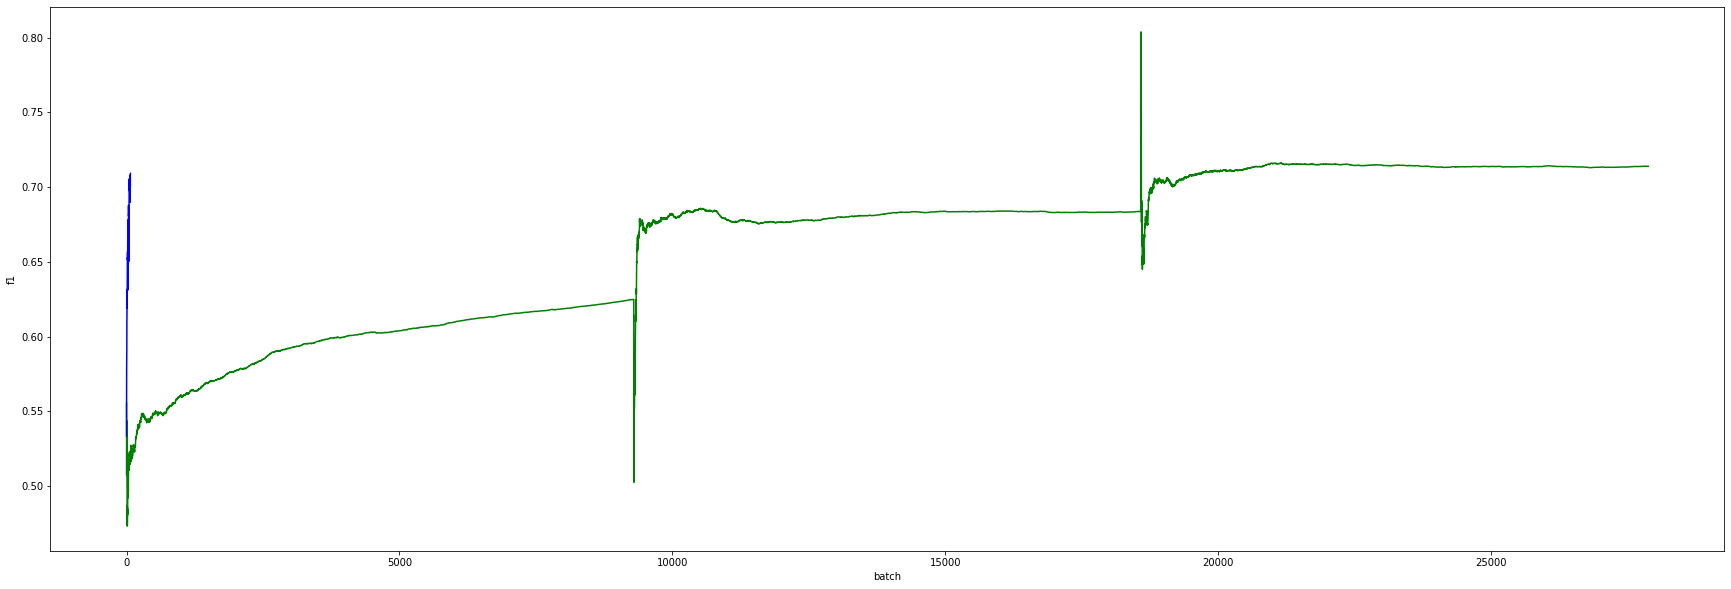

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(scores['train_f1'], 'g', label = 'train f1')
plt.plot(scores['valid_f1'], 'b', label = 'validation f1')
plt.xlabel("batch")
plt.ylabel("f1")
plt.show()

In [ ]:
xlmroberta_ = torch.load(model_path)
xlmroberta.load_state_dict(xlmroberta_)
run_train(args, xlmroberta)

[Epoch 1]



train:   0%|          | 0/9294 [00:00<?, ?it/s]

validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 0

[train] loss : 4.602 accuracy : 0.750 f1 score : 0.631

[validation] loss : 4.618 accuracy : 0.766 f1 score : 0.707



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 400

[train] loss : 4.546 accuracy : 0.783 f1 score : 0.725

[validation] loss : 4.611 accuracy : 0.776 f1 score : 0.724



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 800

[train] loss : 4.563 accuracy : 0.790 f1 score : 0.741

[validation] loss : 4.611 accuracy : 0.776 f1 score : 0.724



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 1200

[train] loss : 4.608 accuracy : 0.790 f1 score : 0.741

[validation] loss : 4.611 accuracy : 0.777 f1 score : 0.722



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 1600

[train] loss : 4.643 accuracy : 0.790 f1 score : 0.741

[validation] loss : 4.614 accuracy : 0.771 f1 score : 0.714



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 2000

[train] loss : 4.675 accuracy : 0.790 f1 score : 0.739

[validation] loss : 4.612 accuracy : 0.777 f1 score : 0.725



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 2400

[train] loss : 4.610 accuracy : 0.789 f1 score : 0.739

[validation] loss : 4.612 accuracy : 0.774 f1 score : 0.717



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 2800

[train] loss : 4.647 accuracy : 0.789 f1 score : 0.738

[validation] loss : 4.615 accuracy : 0.768 f1 score : 0.716



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 3200

[train] loss : 4.567 accuracy : 0.788 f1 score : 0.738

[validation] loss : 4.614 accuracy : 0.770 f1 score : 0.715



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 3600

[train] loss : 4.548 accuracy : 0.788 f1 score : 0.739

[validation] loss : 4.614 accuracy : 0.769 f1 score : 0.717



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 4000

[train] loss : 4.569 accuracy : 0.787 f1 score : 0.739

[validation] loss : 4.612 accuracy : 0.771 f1 score : 0.722



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 4400

[train] loss : 4.611 accuracy : 0.787 f1 score : 0.738

[validation] loss : 4.613 accuracy : 0.771 f1 score : 0.724



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 4800

[train] loss : 4.650 accuracy : 0.787 f1 score : 0.738

[validation] loss : 4.615 accuracy : 0.769 f1 score : 0.720



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 5200

[train] loss : 4.592 accuracy : 0.787 f1 score : 0.738

[validation] loss : 4.613 accuracy : 0.772 f1 score : 0.723



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 5600

[train] loss : 4.571 accuracy : 0.786 f1 score : 0.736

[validation] loss : 4.616 accuracy : 0.769 f1 score : 0.715



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 6000

[train] loss : 4.605 accuracy : 0.785 f1 score : 0.736

[validation] loss : 4.614 accuracy : 0.766 f1 score : 0.711



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 6400

[train] loss : 4.647 accuracy : 0.785 f1 score : 0.735

[validation] loss : 4.614 accuracy : 0.765 f1 score : 0.714



validation:   0%|          | 0/2324 [00:00<?, ?it/s]

[Step] 6800

[train] loss : 4.532 accuracy : 0.785 f1 score : 0.735

[validation] loss : 4.615 accuracy : 0.767 f1 score : 0.717



In [ ]:
xlmroberta_ = torch.load(model_path)
xlmroberta.load_state_dict(xlmroberta_)
run_train(args, xlmroberta)

[Epoch 1]



train:   0%|          | 0/10456 [00:00<?, ?it/s]

validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 0

[train] loss : 4.751 accuracy : 0.688 f1 score : 0.562

[validation] loss : 4.616 accuracy : 0.768 f1 score : 0.707



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 400

[train] loss : 4.623 accuracy : 0.791 f1 score : 0.739

[validation] loss : 4.611 accuracy : 0.777 f1 score : 0.722



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 800

[train] loss : 4.705 accuracy : 0.788 f1 score : 0.737

[validation] loss : 4.611 accuracy : 0.774 f1 score : 0.718



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 1200

[train] loss : 4.583 accuracy : 0.789 f1 score : 0.738

[validation] loss : 4.610 accuracy : 0.774 f1 score : 0.719



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 1600

[train] loss : 4.662 accuracy : 0.788 f1 score : 0.740

[validation] loss : 4.611 accuracy : 0.778 f1 score : 0.725



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 2000

[train] loss : 4.640 accuracy : 0.786 f1 score : 0.737

[validation] loss : 4.610 accuracy : 0.771 f1 score : 0.712



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 2400

[train] loss : 4.672 accuracy : 0.787 f1 score : 0.738

[validation] loss : 4.613 accuracy : 0.766 f1 score : 0.711



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 2800

[train] loss : 4.559 accuracy : 0.785 f1 score : 0.737

[validation] loss : 4.615 accuracy : 0.770 f1 score : 0.713



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 3200

[train] loss : 4.587 accuracy : 0.784 f1 score : 0.735

[validation] loss : 4.616 accuracy : 0.767 f1 score : 0.709



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 3600

[train] loss : 4.679 accuracy : 0.784 f1 score : 0.734

[validation] loss : 4.617 accuracy : 0.764 f1 score : 0.710



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 4000

[train] loss : 4.613 accuracy : 0.784 f1 score : 0.735

[validation] loss : 4.614 accuracy : 0.770 f1 score : 0.713



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 4400

[train] loss : 4.558 accuracy : 0.784 f1 score : 0.736

[validation] loss : 4.612 accuracy : 0.769 f1 score : 0.718



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 4800

[train] loss : 4.552 accuracy : 0.784 f1 score : 0.736

[validation] loss : 4.615 accuracy : 0.760 f1 score : 0.705



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 5200

[train] loss : 4.600 accuracy : 0.784 f1 score : 0.736

[validation] loss : 4.615 accuracy : 0.768 f1 score : 0.716



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 5600

[train] loss : 4.620 accuracy : 0.784 f1 score : 0.736

[validation] loss : 4.612 accuracy : 0.771 f1 score : 0.720



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 6000

[train] loss : 4.535 accuracy : 0.784 f1 score : 0.736

[validation] loss : 4.613 accuracy : 0.770 f1 score : 0.713



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 6400

[train] loss : 4.617 accuracy : 0.783 f1 score : 0.736

[validation] loss : 4.614 accuracy : 0.768 f1 score : 0.714



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 6800

[train] loss : 4.556 accuracy : 0.783 f1 score : 0.736

[validation] loss : 4.616 accuracy : 0.766 f1 score : 0.715



validation:   0%|          | 0/1162 [00:00<?, ?it/s]

[Step] 7200

[train] loss : 4.688 accuracy : 0.783 f1 score : 0.736

[validation] loss : 4.611 accuracy : 0.769 f1 score : 0.718



### Test : final

In [ ]:
# Label encoding


label_encoder = LabelEncoder()
label_encoder.fit(targets)

In [ ]:
label_dict = {}
for x in train_df.digit_1.unique() :
  y = train_df.loc[train_df.digit_1 == x].digit_2.unique()
  
  for lab in y :
    label_dict[int(lab)] = x

#
test_df.fillna(" ", inplace=True)
test_df['text'] = test_df['text_obj'] + " " + test_df['text_mthd'] + " " + test_df['text_deal']
test_df['text'].str.replace(r'\.,/?:$\"~&%!\\‘|\(\)\[\]\<\>`\'#-]', '')
test_text = []
for text in test_df['text']:
  test_text.append(tokenize(text))

#
def testset_tokenizer(args, dataset):

  input_ids_ = []
  attention_mask_ = []

  for sent in dataset:
    try :
      input_ids, attention_mask = sent_tokenizer(sent, MAX_LEN = args['max_seq_length'])

      input_ids_.append(input_ids)
      attention_mask_.append(attention_mask)

    except :
      pass
  
  input_ids_ = np.array(input_ids_, dtype=int)
  attention_mask_ = np.array(attention_mask_, dtype=int)
                             
  dataset_tokenized = {}
  dataset_tokenized['input_ids'] = input_ids_
  dataset_tokenized['attention_mask'] = attention_mask_
  
  return dataset_tokenized

#
test_data = testset_tokenizer(args, test_text)
test_data = CustomDataset(test_data, test=True)
test_loader = DataLoader(test_data, batch_size=32)

#
# model_path = ''
# f = torch.load(model_path)
# model.load_state_dict(f, strict=True)

pred = []

for batch in tqdm(test_loader):

  ids, masks = batch['ids'].to(device), batch['masks'].to(device)

  with torch.no_grad():
    outputs = xlmroberta(input_ids = ids, attention_mask = masks)[0]
    pred.extend(outputs.argmax(dim=1).tolist())

#
test_df['digit_3'] = label_encoder.inverse_transform(pred)
test_df['digit_2'] = test_df['digit_3'].apply(lambda x : int(x.str[:-1]))
test_df['digit_1'] = test_df['digit_2'].apply(lambda x : label_dict(x))

test_df.drop(columns=['text'], inplace=True)